<a href="https://colab.research.google.com/github/hpbowala/Micrograd---Basic-Demo-of-Neural-Networks/blob/main/nnlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
from graphviz import Digraph

In [21]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [88]:
class Value:
  def __init__(self,data,_children=(),_op="",label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):

    out = Value(self.data + other.data, (self,other),'+')

    # self + other = out 
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self,other):
    out = Value(self.data * other.data, (self,other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t= (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value (t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad

    out._backward = _backward

    return out
    
      

In [68]:
a = Value(2.0)
b = Value(3.0)
d = Value(4.0)
c = a * b
e = d + c



a.label = 'a'
b.label = 'b'
c.label = 'c'
d.label = 'd'
e.label = 'e'

l = e.tanh()

l.label = 'l'


0.0


In [73]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'



In [86]:
# dy/dx = f(x+h) - f(x)/h  
# L = d*f
#L.grad = dL/df
# f((f+h)d) - f(d*f) / h
# = df + dh - df /h
# = dh/h
# = d
L.grad = 1.0

# f.grad = d
f.grad = 4
d.grad = -2

'''
d= e+c
dd/de
((e+h)+c) - (e+c)/h
h/h = 1
'''

'''
dL/de = dL/dd * dd/de
= -2 * 1
=-2
'''

e.grad = -2

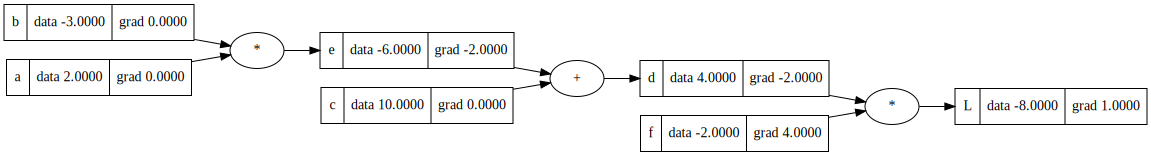

In [87]:
draw_dot(L)

In [119]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-5.494271999999997


In [103]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'





In [ ]:
L.grad = 1
L._backward()
d._backward()
e._backward()

In [117]:
from types import BuiltinFunctionType
#using topological sort to call each backward functions 

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(L)
L.grad = 1.0
for item in reversed(topo):
  item._backward()

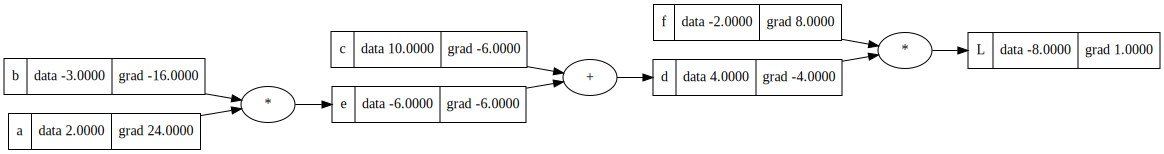

In [118]:
draw_dot(L)

In [113]:
class Value:
  def __init__(self,data,_children=(),_op="",label=""):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):

    out = Value(self.data + other.data, (self,other),'+')

    # self + other = out 
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self,other):
    out = Value(self.data * other.data, (self,other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t= (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value (t, (self, ), 'tanh')

    def _backward():
      self.grad = (1-t**2) * out.grad

    out._backward = _backward

    return out
    
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    self.grad = 1.0
    for item in reversed(topo):
      item._backward()

      

In [122]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'

In [124]:
L.backward()

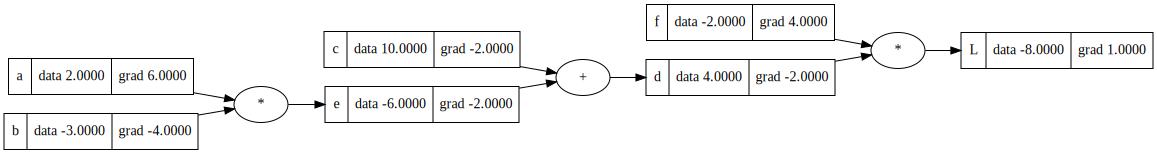

In [125]:
draw_dot(L)

In [ ]:
# Modifying the Finalized Value 